In [43]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd

import matplotlib.pyplot as plt
import seaborn as sns


In [44]:
try:
    from ucimlrepo import fetch_ucirepo
except ImportError:
    print("Please install the ucimlrepo with pip :)")

In [45]:
# fetch dataset 
cirrhosis_patient_survival_prediction = fetch_ucirepo(id=878) 
  
# data (as pandas dataframes) 
X = cirrhosis_patient_survival_prediction.data.features 
  
# metadata 
print(cirrhosis_patient_survival_prediction.metadata) 
  
# variable information 
print(cirrhosis_patient_survival_prediction.variables)

data = pd.DataFrame(X)

{'uci_id': 878, 'name': 'Cirrhosis Patient Survival Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/878/cirrhosis+patient+survival+prediction+dataset-1', 'data_url': 'https://archive.ics.uci.edu/static/public/878/data.csv', 'abstract': 'Utilize 17 clinical features for predicting survival state of patients with liver cirrhosis. The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation).', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 418, 'num_features': 17, 'feature_types': ['Real', 'Categorical'], 'demographics': ['Age', 'Sex'], 'target_col': ['Status'], 'index_col': ['ID'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5R02G', 'creators': ['E. Dickson', 'P. Grambsch', 'T. Fleming', 'L. Fisher', 'A. Langworthy'], 'intro_paper': {'ID': 296, 'type'

In [5]:
print(data.head())

              Drug    Age Sex Ascites Hepatomegaly Spiders Edema  Bilirubin  \
0  D-penicillamine  21464   F       Y            Y       Y     Y       14.5   
1  D-penicillamine  20617   F       N            Y       Y     N        1.1   
2  D-penicillamine  25594   M       N            N       N     S        1.4   
3  D-penicillamine  19994   F       N            Y       Y     S        1.8   
4          Placebo  13918   F       N            Y       Y     N        3.4   

  Cholesterol  Albumin Copper  Alk_Phos    SGOT Tryglicerides Platelets  \
0         261     2.60    156    1718.0  137.95           172       190   
1         302     4.14     54    7394.8  113.52            88       221   
2         176     3.48    210     516.0   96.10            55       151   
3         244     2.54     64    6121.8   60.63            92       183   
4         279     3.53    143     671.0  113.15            72       136   

   Prothrombin  Stage  
0         12.2    4.0  
1         10.6    3.0  
2 

In [6]:
#data preparation and cleaning

data = data.replace('NaNN', np.nan)

cols = data.columns

na_per_col = {}

for col in cols:
    na_per_col[col] = data[col].isna().sum()


for key, value in na_per_col.items():
    print(key, value)

Drug 106
Age 0
Sex 0
Ascites 106
Hepatomegaly 106
Spiders 106
Edema 0
Bilirubin 0
Cholesterol 134
Albumin 0
Copper 108
Alk_Phos 106
SGOT 106
Tryglicerides 136
Platelets 11
Prothrombin 2
Stage 6


# Scaling the data

In [53]:
# Select only numeric columns from the data
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Fill missing values in the numeric columns with their respective means
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())


In [54]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns for scaling
num_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Initialize the scaler
scaler = StandardScaler()

# Scale numerical columns only
data[num_cols] = scaler.fit_transform(data[num_cols])


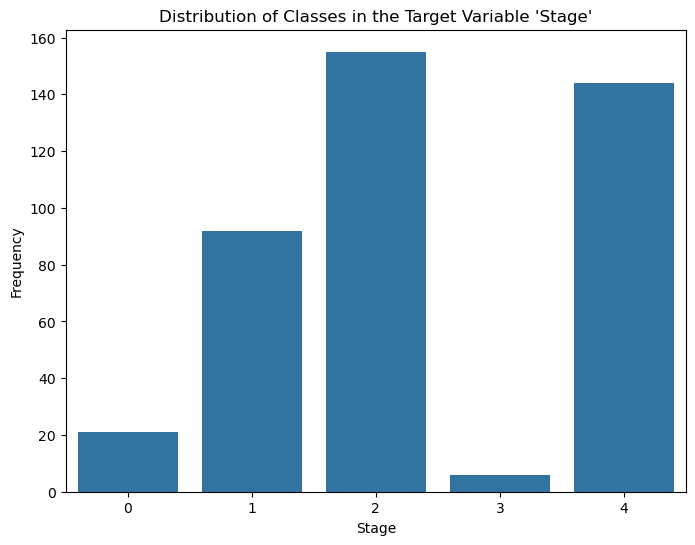

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target variable (Stage)
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Stage')
plt.title("Distribution of Classes in the Target Variable 'Stage'")
plt.xlabel("Stage")
plt.ylabel("Frequency")
plt.show()


# Baseline model

In [66]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize outer cross-validation
K1 = 10
outer_cv = StratifiedKFold(n_splits=K1, shuffle=True, random_state=42)

# Array to store test errors for the baseline model
baseline_test_errors = []

# Outer loop with fold tracking
fold_number = 1
for train_index, test_index in outer_cv.split(X, y):
    print(f"Outer Fold {fold_number}")
    
    X_train_outer, X_test_outer = X[train_index], X[test_index]
    y_train_outer, y_test_outer = y[train_index], y[test_index]

    # Baseline model (predicts most frequent class)
    baseline_model = DummyClassifier(strategy="most_frequent")
    baseline_model.fit(X_train_outer, y_train_outer)
    y_pred_baseline = baseline_model.predict(X_test_outer)
    baseline_test_error = 1 - accuracy_score(y_test_outer, y_pred_baseline)
    baseline_test_errors.append(baseline_test_error)
    
    # Print the test error for this fold
    print(f"Baseline Model Test Error for Fold {fold_number}: {baseline_test_error}\n")
    fold_number += 1

# Display average test errors for the baseline model
print("Baseline Model Test Errors (Outer CV):", baseline_test_errors)
print("Average Baseline Test Error:", np.mean(baseline_test_errors))


Outer Fold 1
Baseline Model Test Error for Fold 1: 0.6428571428571428

Outer Fold 2
Baseline Model Test Error for Fold 2: 0.6428571428571428

Outer Fold 3
Baseline Model Test Error for Fold 3: 0.6428571428571428

Outer Fold 4
Baseline Model Test Error for Fold 4: 0.6428571428571428

Outer Fold 5
Baseline Model Test Error for Fold 5: 0.6190476190476191

Outer Fold 6
Baseline Model Test Error for Fold 6: 0.6190476190476191

Outer Fold 7
Baseline Model Test Error for Fold 7: 0.6190476190476191

Outer Fold 8
Baseline Model Test Error for Fold 8: 0.6190476190476191

Outer Fold 9
Baseline Model Test Error for Fold 9: 0.6097560975609756

Outer Fold 10
Baseline Model Test Error for Fold 10: 0.6341463414634146

Baseline Model Test Errors (Outer CV): [0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6190476190476191, 0.6190476190476191, 0.6190476190476191, 0.6190476190476191, 0.6097560975609756, 0.6341463414634146]
Average Baseline Test Error: 0.6291521486643437


c:\Users\Lucija\anaconda3\envs\my-env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


# Logistic regression

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize outer cross-validation
K1 = 10
outer_cv = StratifiedKFold(n_splits=K1, shuffle=True, random_state=42)

# Array to store test errors for logistic regression
log_reg_test_errors = []

# Outer loop with fold tracking
fold_number = 1
for train_index, test_index in outer_cv.split(X, y):
    print(f"Outer Fold {fold_number}")
    
    X_train_outer, X_test_outer = X[train_index], X[test_index]
    y_train_outer, y_test_outer = y[train_index], y[test_index]

    # Inner loop cross-validation for logistic regression parameter tuning
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_score = -np.inf
    best_lambda = None
    for C in [0.01, 0.05, 0.1, 0.5, 1.0]:  # Inverse of λ in LogisticRegression
        log_reg = LogisticRegression(C=C, max_iter=1000, random_state=42)
        scores = cross_val_score(log_reg, X_train_outer, y_train_outer, cv=inner_cv, scoring='accuracy')
        if scores.mean() > best_score:
            best_score = scores.mean()
            best_lambda = C

    # Train logistic regression with the best λ on the outer training set
    log_reg = LogisticRegression(C=best_lambda, max_iter=1000, random_state=42)
    log_reg.fit(X_train_outer, y_train_outer)
    y_pred_log_reg = log_reg.predict(X_test_outer)
    log_reg_test_error = 1 - accuracy_score(y_test_outer, y_pred_log_reg)
    log_reg_test_errors.append(log_reg_test_error)
    
    # Print the test error for this fold
    print(f"Logistic Regression Test Error for Fold {fold_number}: {log_reg_test_error}\n")
    fold_number += 1

# Display average test errors for logistic regression
print("Logistic Regression Test Errors (Outer CV):", log_reg_test_errors)
print("Average Logistic Regression Test Error:", np.mean(log_reg_test_errors))


c:\Users\Lucija\anaconda3\envs\my-env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


Outer Fold 1
Logistic Regression Test Error for Fold 1: 0.5952380952380952

Outer Fold 2
Logistic Regression Test Error for Fold 2: 0.6428571428571428

Outer Fold 3
Logistic Regression Test Error for Fold 3: 0.4285714285714286

Outer Fold 4
Logistic Regression Test Error for Fold 4: 0.6666666666666667

Outer Fold 5
Logistic Regression Test Error for Fold 5: 0.5

Outer Fold 6
Logistic Regression Test Error for Fold 6: 0.45238095238095233

Outer Fold 7
Logistic Regression Test Error for Fold 7: 0.40476190476190477

Outer Fold 8
Logistic Regression Test Error for Fold 8: 0.5476190476190477

Outer Fold 9
Logistic Regression Test Error for Fold 9: 0.5853658536585367

Outer Fold 10
Logistic Regression Test Error for Fold 10: 0.6829268292682926

Logistic Regression Test Errors (Outer CV): [0.5952380952380952, 0.6428571428571428, 0.4285714285714286, 0.6666666666666667, 0.5, 0.45238095238095233, 0.40476190476190477, 0.5476190476190477, 0.5853658536585367, 0.6829268292682926]
Average Logistic Re